# **Image Pre-Processing**



Defining necessary variables and importing libraries

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout,Activation,Flatten
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics
from keras.layers import Input
from tqdm import tqdm
from keras.applications.imagenet_utils import preprocess_input
import time
import itertools
import pandas as pd
from keras.preprocessing import image
from PIL import Image, ImageDraw
import cv2
from scipy import ndimage
import csv

output = "/content/drive/My Drive/Thesis/Processed_Images"
angles1 = [36,50,72,108,144,180,216,252,288,324]
angles2 = [144,180]
angles3 = [72]
width = 300
height = 300

Unzipping original image folder (this has to be done everytime the session restarts)

In [0]:
!unzip /content/drive/My\ Drive/Thesis/images.zip

Masking and rotating **training images** belonging to class '0' (uninfected)

In [0]:
csv_file = pd.read_csv('/content/drive/My Drive/Thesis/CNN/Train_Cat.csv')
csv_file = pd.DataFrame(csv_file)
csv_file = csv_file.query('Category==0')

for i in csv_file['image']:
    img = image.load_img('/content/images/'+str(i)+'.png', target_size=(224,224,3), grayscale=False)
    bigsize = (img.size[0] * 3, img.size[1] * 3)
    mask = Image.new('L',bigsize, 0)
    draw = ImageDraw.Draw(mask) 
    draw.ellipse((0, 0) + bigsize, fill=255)
    mask = mask.resize(img.size, Image.ANTIALIAS)
    img.putalpha(mask)
    for angle in angles1:
        rotated = ndimage.rotate(img, angle)
        out = os.path.join(output, str(angle)+'_'+str(i)+'.png')
        cv2.imwrite(out, rotated)

Masking and rotating **training images** belonging to class '1' (infected)

In [0]:
csv_file = pd.read_csv('/content/drive/My Drive/Thesis/CNN/Train_Cat.csv')
csv_file = pd.DataFrame(csv_file)
csv_file = csv_file.query('Category==1')

for i in csv_file['image']:
    img = image.load_img('/content/images/'+str(i)+'.png', target_size=(224,224,3), grayscale=False)
    bigsize = (img.size[0] * 3, img.size[1] * 3)
    mask = Image.new('L',bigsize, 0)
    draw = ImageDraw.Draw(mask) 
    draw.ellipse((0, 0) + bigsize, fill=255)
    mask = mask.resize(img.size, Image.ANTIALIAS)
    img.putalpha(mask)
    for angle in angles2:
        rotated = ndimage.rotate(img, angle)
        out = os.path.join(output, str(angle)+'_'+str(i)+'.png')
        cv2.imwrite(out, rotated)

Masking and rotating **test images** belonging to class '0' (uninfected)

In [0]:
csv_file = pd.read_csv('/content/drive/My Drive/Thesis/CNN/Test_Cat.csv')
csv_file = pd.DataFrame(csv_file)
csv_file = csv_file.query('Category==0')

for i in csv_file['image']:
    img = image.load_img('/content/images/'+str(i)+'.png', target_size=(224,224,3), grayscale=False)
    bigsize = (img.size[0] * 3, img.size[1] * 3)
    mask = Image.new('L',bigsize, 0)
    draw = ImageDraw.Draw(mask) 
    draw.ellipse((0, 0) + bigsize, fill=255)
    mask = mask.resize(img.size, Image.ANTIALIAS)
    img.putalpha(mask)
    for angle in angles1:
        rotated = ndimage.rotate(img, angle)
        out = os.path.join(output, str(angle)+'_'+str(i)+'.png')
        cv2.imwrite(out, rotated)

Masking and rotating **test images** belonging to class '1' (infected)

In [0]:
csv_file = pd.read_csv('/content/drive/My Drive/Thesis/CNN/Test_Cat.csv')
csv_file = pd.DataFrame(csv_file)
csv_file = csv_file.query('Category==1')

for i in csv_file['image']:
    img = image.load_img('/content/images/'+str(i)+'.png', target_size=(224,224,3), grayscale=False)
    bigsize = (img.size[0] * 3, img.size[1] * 3)
    mask = Image.new('L',bigsize, 0)
    draw = ImageDraw.Draw(mask) 
    draw.ellipse((0, 0) + bigsize, fill=255)
    mask = mask.resize(img.size, Image.ANTIALIAS)
    img.putalpha(mask)
    for angle in angles3:
        rotated = ndimage.rotate(img, angle)
        out = os.path.join(output, str(angle)+'_'+str(i)+'.png')
        cv2.imwrite(out, rotated)

# **Modifying csv files as per new image name with angle concatenated at the front**

The output form this code returns just the image names concatenated with respective angle. Vlookup was then applied in excel to original file to fetch respective classes.

Modifying trainng csv file

In [0]:
with open('/content/drive/My Drive/Thesis/CNN/Train_Cat.csv','r') as readfile:
    reader = csv.reader(readfile, delimiter=',')
    next(reader)
    with open('/content/drive/My Drive/Thesis/Train_Categorized.csv', 'w', newline='') as writefile:
        writer = csv.writer(writefile, delimiter=',')
        for line in reader:
            if line[1] == str(0):
                for x in angles1:
                    writer.writerow([str(x)+'_'+line[0]])
            else:
                for a in angles2:
                    writer.writerow([str(a)+'_'+line[0]])

Modifying test csv file

In [0]:
with open('/content/drive/My Drive/Thesis/CNN/Test_Cat.csv','r') as readfile:
    reader = csv.reader(readfile, delimiter=',')
    next(reader)
    with open('/content/drive/My Drive/Thesis/Test_Categorized.csv', 'w', newline='') as writefile:
        writer = csv.writer(writefile, delimiter=',')
        for line in reader:
            if line[1] == str(0):
                for x in angles1:
                    writer.writerow([str(x)+'_'+line[0]])
            else:
                for a in angles3:
                    writer.writerow([str(a)+'_'+line[0]])

# **ResNet-50**

Loading and storing training images in numpy array as well as changing shape of array as required by ResNet-50 model

In [0]:
train = pd.read_csv('/content/drive/My Drive/Thesis/Train_Categorized.csv')

train_image = []

for i in tqdm(range(train.shape[0])):
    img = image.load_img('/content/drive/My Drive/Thesis/Processed_Images/'+str(train['image'][i])+'.png', target_size=(224,224,3), grayscale=False)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
	  #print('Input image shape:', img.shape)
    train_image.append(img)
    cv2.waitKey(2)

X = np.array(train_image)

print (X.shape)
X=np.rollaxis(X,1,0)
print (X.shape)
X=X[0]
print (X.shape)


y=train['category'].values
y = to_categorical(y)

100%|██████████| 3928/3928 [00:27<00:00, 142.31it/s]


(3928, 1, 224, 224, 3)
(1, 3928, 224, 224, 3)
(3928, 224, 224, 3)


Preparing training and validation sets

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

Building a pre-trained ResNet-50 model, adding 6 new layers in it and making only those layers trainable

In [0]:
num_classes = 2

image_input = Input(shape=(224, 224, 3))

model = ResNet50(weights='imagenet',include_top=False)

last_layer = model.output
x = GlobalAveragePooling2D()(last_layer)
# add fully-connected & dropout layers
x = Dense(512, activation='softmax',name='fc-1')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu',name='fc-2')(x)
x = Dropout(0.5)(x)
# a softmax layer for 2 classes
out = Dense(num_classes, activation='softmax',name='output_layer')(x)

# this is the model we will train
custom_resnet_model2 = Model(inputs=model.input, outputs=out)

for layer in custom_resnet_model2.layers[:-6]:
	layer.trainable = False

#custom_resnet_model2.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Compiling and fitting the model for 20 epochs and recording the training time

In [0]:
custom_resnet_model2.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])
t=time.time()
hist = custom_resnet_model2.fit(X_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))

Train on 3142 samples, validate on 786 samples
Epoch 1/20
3142/3142 [==============================] - 21s 7ms/step - loss: 0.6920 - acc: 0.5248 - val_loss: 0.6957 - val_acc: 0.4758
Epoch 2/20
3142/3142 [==============================] - 16s 5ms/step - loss: 0.6907 - acc: 0.5296 - val_loss: 0.6970 - val_acc: 0.4758
Epoch 3/20
3142/3142 [==============================] - 16s 5ms/step - loss: 0.6904 - acc: 0.5296 - val_loss: 0.6971 - val_acc: 0.4758
Epoch 4/20
3142/3142 [==============================] - 16s 5ms/step - loss: 0.6902 - acc: 0.5296 - val_loss: 0.6967 - val_acc: 0.4758
Epoch 5/20
3142/3142 [==============================] - 16s 5ms/step - loss: 0.6900 - acc: 0.5296 - val_loss: 0.6964 - val_acc: 0.4758
Epoch 6/20
3142/3142 [==============================] - 16s 5ms/step - loss: 0.6899 - acc: 0.5296 - val_loss: 0.6967 - val_acc: 0.4758
Epoch 7/20
3142/3142 [==============================] - 16s 5ms/step - loss: 0.6896 - acc: 0.5296 - val_loss: 0.6965 - val_acc: 0.4758
Epoch 8/

Plotting training accuracy and loss and validation accuracy and loss

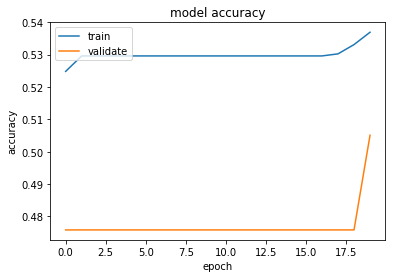

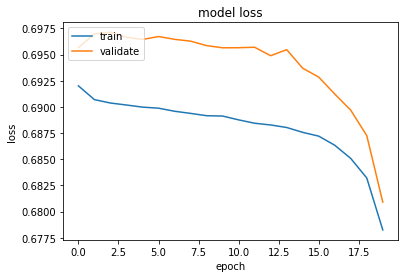

In [0]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

Loading and storing test images in numpy array as well as changing shape of array as required by ResNet-50 model

In [0]:
test = pd.read_csv('/content/drive/My Drive/Thesis/Test_Categorized.csv')

test_image = []

for i in tqdm(range(test.shape[0])):
    img = image.load_img('/content/drive/My Drive/Thesis/Processed_Images/'+str(test['image'][i])+'.png', target_size=(224,224,3), grayscale=False)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
	  #print('Input image shape:', img.shape)
    test_image.append(img)
    cv2.waitKey(2)

test_set = np.array(test_image)

print (test_set.shape)
test_set=np.rollaxis(test_set,1,0)
print (test_set.shape)
test_set=test_set[0]
print (test_set.shape)

x=test['category'].values
x = to_categorical(x)

100%|██████████| 147/147 [00:00<00:00, 188.89it/s]


(147, 1, 224, 224, 3)
(1, 147, 224, 224, 3)
(147, 224, 224, 3)


Making predictions

In [0]:
prediction = custom_resnet_model2.predict(test_set,verbose=0)
prediction = np.argmax(prediction,axis=1)
accuracy = accuracy_score(test['category'],prediction)
print('Accuracy: ', accuracy*100, '%')

Accuracy:  79.59183673469387 %


Function for confusion matrix

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Computing confusion matrix

In [0]:
cnf_matrix = confusion_matrix(test['category'],prediction)
np.set_printoptions(precision=2)

Plotting confusion matrix and calculating accuracy, precision, recall and F1-Score

Confusion matrix, without normalization
[[  0  30]
 [  0 117]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.80      1.00      0.89       117

    accuracy                           0.80       147
   macro avg       0.40      0.50      0.44       147
weighted avg       0.63      0.80      0.71       147



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


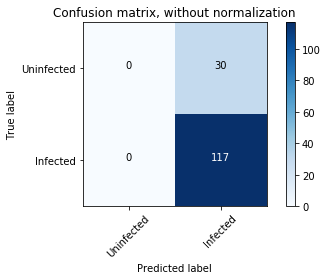

In [0]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Uninfected','Infected'],
                      title='Confusion matrix, without normalization')

print(classification_report(test['category'],prediction))